# Drought Prediction in the Mediterranean

In [1]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import KBinsDiscretizer, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, plot_confusion_matrix
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

In [6]:
# # Train/Test Split - Just run once
# X_tas = np.load('Data/tas_train.npy')
# X_psl = np.load('Data/psl_train.npy')
# y=np.load('Data/nao_index_train.npy')

# X = np.concatenate((X_tas, X_psl),axis=1)
# y=y.reshape(-1,1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# np.save('Data/train/X_train.npy', X_train)
# np.save('Data/test/X_test.npy', X_test)
# np.save('Data/train/y_train.npy', y_train)
# np.save('Data/test/y_test.npy', y_test)

# Exploratory Data Analysis

In [2]:
#Load training data
X_train = np.load('Data/train/X_train.npy')
y_train = np.load('Data/train/y_train.npy')
print(X_train.shape)
print(y_train.shape)

(720, 4644)
(720, 1)


In [3]:
# Data are standardized by column
X_df = pd.DataFrame(X_train)
print("Range of means: ",X_df.mean().max() - X_df.mean().min())
print("Range of stdevs: ",X_df.std().max() - X_df.std().min())

Range of means:  0.10698490791697654
Range of stdevs:  0.09475504033032955


In [4]:
# No missing data (synthetic dataset, so none are expected)
X_df.isna().sum().sum()

0

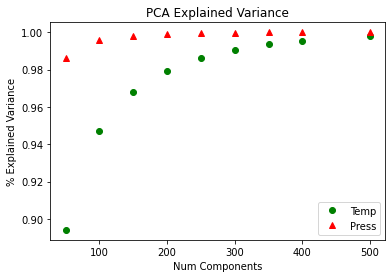

In [5]:
# PCA - Virtually all variance is explained in the first 200 PCs of press and the first 500 PCs of temp
num_components = [50,100,150,200,250,300,350,400,500]
explained_variance_temp = []
explained_variance_press = []
for i in num_components:
    pca_temp = PCA(n_components=i)
    pca_press = PCA(n_components=i)
    X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
    X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
    explained_variance_temp.append(pca_temp.explained_variance_ratio_.sum())
    explained_variance_press.append(pca_press.explained_variance_ratio_.sum())

    
plt.plot(num_components,explained_variance_temp,'go',label="Temp")
plt.plot(num_components,explained_variance_press,"r^",label="Press")
plt.title("PCA Explained Variance")
plt.xlabel("Num Components")
plt.ylabel("% Explained Variance")
plt.legend(loc="lower right")
plt.show()


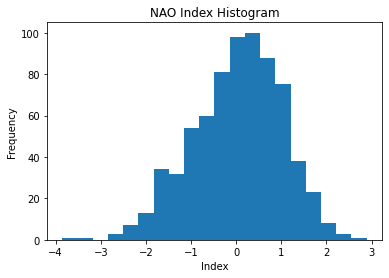

In [6]:
np.histogram(y_train, bins=20);
plt.title("NAO Index Histogram")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.hist(y_train,bins=20)
plt.show()

#### Investigate Correlation between target variable and each coordinate

In [7]:
data = pd.DataFrame(X_train)

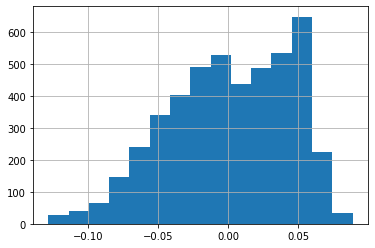

In [8]:
data.corrwith(pd.Series(y_train.reshape(720,))).hist(bins=15);

# Preprocessing

In [6]:
# Transform Training Data with PCA
pca_temp = PCA(n_components=125)
pca_press = PCA(n_components=50)
# After feedback from Eduardo Zorita, reduced the number of PCs.
# pca_temp = PCA(n_components=15)
# pca_press = PCA(n_components=15)

X_tas_pca = pca_temp.fit_transform(X_train[:,0:2322])
X_psl_pca = pca_press.fit_transform(X_train[:,2322:4645])
X_train_pca = np.concatenate((X_tas_pca,X_psl_pca),axis=1)

In [7]:
# Calculate reconstruction error
X_tas_projected = pca_temp.inverse_transform(X_tas_pca)
X_psl_projected = pca_press.inverse_transform(X_psl_pca)
loss_temp = ((X_train[:,0:2322]-X_tas_projected)**2).mean()
loss_press = ((X_train[:,2322:4645]-X_psl_projected)**2).mean()
print('MSE Temp: '+str(loss_temp))
print('MSE Press: '+str(loss_press))

MSE Temp: 0.039978632135274396
MSE Press: 0.013623849179161466


In [8]:
y_train_bin = np.sign(y_train).reshape(-1,)
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
# kbin = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

# y_train_cat= kbin.fit_transform(y_train.reshape(-1,1)).reshape(-1,)
# print(pd.Series(y_train_cat).value_counts())
# print(kbin.bin_edges_)

# Random Forest Classifier
## Binary Classification (positive or negative NAOI)

In [9]:
rf = RandomForestClassifier(random_state=1337)

In [10]:
# HPO without PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1')
clf.fit(X_train,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.6518982229762063
{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}


Best F1 Score: 0.6518982229762063

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}

In [11]:
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.758310,0.127190,0.013613,0.001219,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.666667,0.583784,0.683938,0.630435,0.617801,0.636525,0.035569,3
1,2.740571,0.119680,0.012509,0.000422,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.606383,0.604396,0.666667,0.622951,0.652406,0.630560,0.024932,6
2,2.908190,0.036275,0.011998,0.000249,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.612022,0.585635,0.666667,0.605405,0.639175,0.621781,0.028239,7
3,2.770911,0.042325,0.012379,0.000459,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.613757,0.607735,0.694737,0.633880,0.630435,0.636109,0.030916,4
4,1.528268,0.035313,0.013874,0.001547,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.620321,0.642487,0.713568,0.623656,0.659459,0.651898,0.033893,1
5,1.492679,0.032881,0.012194,0.000387,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.627660,0.595745,0.634921,0.645161,0.652632,0.631224,0.019686,5
6,1.702611,0.038729,0.013588,0.001336,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.608696,0.652632,0.670157,0.602273,0.688172,0.644386,0.033754,2
7,1.674827,0.069773,0.012906,0.000868,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.627027,0.568306,0.673575,0.595506,0.641304,0.621144,0.036440,8


In [12]:
# HPO with PCA
## Random Forest ##
parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
clf = GridSearchCV(rf, parameters,scoring='f1')
clf.fit(X_train_pca,y_train_bin)
print(clf.best_score_)
print(clf.best_params_)

0.6820079069364086
{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 15}


Best F1 Score: 0.6820079069364086

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 15}

In [13]:
# Equal if not better performance when using PCA transform
results = pd.DataFrame(clf.cv_results_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.732737,0.181178,0.024518,0.002956,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.690000,0.683417,0.670103,0.676768,0.686869,0.681431,0.007170,2
1,1.490977,0.056872,0.028521,0.002933,entropy,10,15,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.680412,0.686567,0.680628,0.656566,0.670051,0.674845,0.010573,4
2,1.784997,0.137922,0.032681,0.011376,entropy,100,5,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.690355,0.626263,0.673684,0.630000,0.616216,0.647304,0.029182,8
3,1.973995,0.207036,0.040556,0.011983,entropy,100,15,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",0.680628,0.690000,0.715026,0.645833,0.670213,0.680340,0.022759,3
4,1.165604,0.212884,0.038262,0.012954,gini,10,5,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.692308,0.683168,0.663212,0.670000,0.653061,0.672350,0.013974,5
5,1.022668,0.081241,0.025369,0.004742,gini,10,15,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.673267,0.703518,0.683168,0.673469,0.676617,0.682008,0.011335,1
6,1.034553,0.027250,0.026597,0.006918,gini,100,5,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.676923,0.715026,0.645503,0.673469,0.618557,0.665896,0.032402,6
7,1.077076,0.056846,0.030227,0.005294,gini,100,15,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",0.635897,0.666667,0.663212,0.646465,0.663212,0.655091,0.011906,7


In [14]:
# Persist RF wPCA Model
with open('Data/RF_Bin_wPCA', 'wb') as f:
    pickle.dump(clf, f)

## Testing

In [15]:
# Load Test Data
X_test = np.load('Data/test/X_test.npy')
y_test = np.load('Data/test/y_test.npy')

In [16]:
#transform test data
X_tas_pca_test = pca_temp.transform(X_test[:,0:2322])
X_psl_pca_test = pca_press.transform(X_test[:,2322:4645])
X_test_pca = np.concatenate((X_tas_pca_test,X_psl_pca_test),axis=1)
y_test_bin = np.sign(y_test)


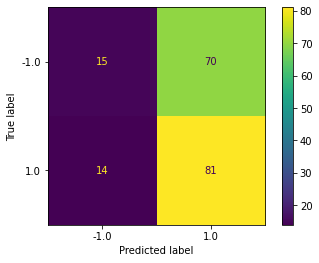

In [17]:
plot_confusion_matrix(clf, X_test_pca, y_test_bin)

In [18]:
y_pred = clf.predict(X_test_pca)

In [19]:
print('F1 score: '+str(f1_score(y_test_bin, y_pred, average='binary')))

F1 score: 0.6585365853658537


In [20]:
np.unique(y_test_bin, return_counts=True)

(array([-1.,  1.]), array([85, 95], dtype=int64))

# Autoencoder

In [27]:
import keras
from keras import layers
from keras.optimizers import Adam

In [55]:
# Simplest Autoencoder - This did not perform well. The loss remained the same at each epoch
# encoding_dim = 255
# input_img = keras.Input(shape=(54,43,))
# encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# decoded = layers.Dense(2322, activation='sigmoid')(encoded)
# autoencoder = keras.Model(input_img, decoded)
# encoder = keras.Model(input_img, encoded)
# encoded_input = keras.Input(shape=(encoding_dim,))
# decoder_layer = autoencoder.layers[-1]
# decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
# customAdam = Adam(lr=0.001)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [71]:
# Convolutional Encoder
input_img = keras.Input(shape=(54,43,1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = layers.ZeroPadding2D(padding=((0,2),(0,5)))(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
print('encoded',encoded.shape)

# at this point the representation is (7,6,8) i.e. 336-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Cropping2D(cropping=((0,2),(0,5)))(x)
print('Cropped',x.shape)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)

(None, 54, 43, 16)
(None, 56, 48, 16)
(None, 28, 24, 16)
(None, 28, 24, 8)
(None, 14, 12, 8)
(None, 14, 12, 8)
encoded (None, 7, 6, 8)
(None, 7, 6, 8)
(None, 14, 12, 8)
(None, 14, 12, 8)
(None, 28, 24, 8)
(None, 28, 24, 16)
(None, 56, 48, 16)
Cropped (None, 54, 43, 16)
(None, 54, 43, 1)


In [73]:
input_img = keras.Input(shape=(54,43,1))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = layers.ZeroPadding2D(padding=((0,2),(0,5)))(x)
print(x.shape)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
print('encoded',encoded.shape)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = layers.Cropping2D(cropping=((0,2),(0,5)))(x)
print(x.shape)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)

(None, 54, 43, 16)
(None, 56, 48, 16)
encoded (None, 28, 24, 16)
(None, 28, 24, 16)
(None, 56, 48, 16)
(None, 54, 43, 16)
(None, 54, 43, 1)


In [74]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## Preprocessing

In [75]:
# For convolutional autoencoder
X_train_temp_auto = X_train[:,0:2322].reshape((720,54,43))
X_train_press_auto = X_train[:,2322:4645].reshape((720,54,43))
X_test_temp_auto = X_test[:,0:2322].reshape((180,54,43))
X_test_press_auto = X_test[:,2322:4645].reshape((180,54,43))

## Train the Autoencoder

In [76]:
autoencoder.fit(X_train_press_auto, X_train_press_auto, epochs=100, batch_size=25, shuffle=True, validation_data=(X_test_press_auto, X_test_press_auto))

Epoch 1/100
29/29 [==============================] - 2s 56ms/step - loss: -0.9251 - val_loss: -3.2026
Epoch 2/100
29/29 [==============================] - 2s 52ms/step - loss: -5.3084 - val_loss: -6.3749
Epoch 3/100
29/29 [==============================] - 2s 53ms/step - loss: -6.5506 - val_loss: -6.5931
Epoch 4/100
29/29 [==============================] - 2s 53ms/step - loss: -6.6715 - val_loss: -6.6703
Epoch 5/100
29/29 [==============================] - 2s 53ms/step - loss: -6.7378 - val_loss: -6.7266
Epoch 6/100
29/29 [==============================] - 2s 54ms/step - loss: -6.7871 - val_loss: -6.7673
Epoch 7/100
29/29 [==============================] - 2s 55ms/step - loss: -6.8221 - val_loss: -6.7956
Epoch 8/100
29/29 [==============================] - 2s 57ms/step - loss: -6.8468 - val_loss: -6.8170
Epoch 9/100
29/29 [==============================] - 2s 57ms/step - loss: -6.8659 - val_loss: -6.8337
Epoch 10/100
29/29 [==============================] - 2s 58ms/step - loss: -6.8808

29/29 [==============================] - 2s 60ms/step - loss: -7.0897 - val_loss: -7.0511
Epoch 81/100
29/29 [==============================] - 2s 60ms/step - loss: -7.0899 - val_loss: -7.0516
Epoch 82/100
29/29 [==============================] - 2s 63ms/step - loss: -7.0905 - val_loss: -7.0518
Epoch 83/100
29/29 [==============================] - 2s 63ms/step - loss: -7.0909 - val_loss: -7.0524
Epoch 84/100
29/29 [==============================] - 2s 61ms/step - loss: -7.0913 - val_loss: -7.0526
Epoch 85/100
29/29 [==============================] - 2s 63ms/step - loss: -7.0916 - val_loss: -7.0530
Epoch 86/100
29/29 [==============================] - 2s 64ms/step - loss: -7.0919 - val_loss: -7.0529
Epoch 87/100
29/29 [==============================] - 2s 62ms/step - loss: -7.0924 - val_loss: -7.0538
Epoch 88/100
29/29 [==============================] - 2s 60ms/step - loss: -7.0927 - val_loss: -7.0540
Epoch 89/100
29/29 [==============================] - 2s 60ms/step - loss: -7.0930 - v

In [77]:
X_train_autoencoder = autoencoder.predict(X_train_temp_auto)
mse = ((X_train_temp_auto-X_train_autoencoder.reshape((720,54,43)))**2).mean()
print(mse)


0.5912405100637436


#### This MSE is far worse than that of the PCA transform

# Try XGBoost

In [21]:
import xgboost as xgb

In [22]:
y_train_bin_xg = Binarizer().fit_transform(y_train)
y_test_bin_xg = Binarizer().fit_transform(y_test)
dtrain = xgb.DMatrix(X_train_pca, label=y_train_bin_xg)
dtest = xgb.DMatrix(X_test_pca, label=y_test_bin_xg)

In [23]:
param = {'max_depth':100, 'eta':1, 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'
evallist = [(dtest,'eval'),(dtrain,'train')]
num_round = 20

In [24]:
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	eval-auc:0.49567	train-auc:0.98282
[1]	eval-auc:0.53071	train-auc:0.99990
[2]	eval-auc:0.52768	train-auc:1.00000
[3]	eval-auc:0.53226	train-auc:1.00000
[4]	eval-auc:0.52050	train-auc:1.00000
[5]	eval-auc:0.50861	train-auc:1.00000
[6]	eval-auc:0.51096	train-auc:1.00000
[7]	eval-auc:0.50514	train-auc:1.00000
[8]	eval-auc:0.51703	train-auc:1.00000
[9]	eval-auc:0.52099	train-auc:1.00000
[10]	eval-auc:0.52000	train-auc:1.00000
[11]	eval-auc:0.52000	train-auc:1.00000
[12]	eval-auc:0.52768	train-auc:1.00000
[13]	eval-auc:0.52656	train-auc:1.00000
[14]	eval-auc:0.52780	train-auc:1.00000
[15]	eval-auc:0.52892	train-auc:1.00000
[16]	eval-auc:0.51901	train-auc:1.00000
[17]	eval-auc:0.51529	train-auc:1.00000
[18]	eval-auc:0.51591	train-auc:1.00000
[19]	eval-auc:0.52186	train-auc:1.00000


In [25]:
y_pred = bst.predict(xgb.DMatrix(X_test_pca))
y_pred_bin = y_pred>=0.5

In [26]:
print('F1 score: '+str(f1_score(y_test_bin_xg, y_pred_bin, average='binary')))

F1 score: 0.5728155339805826


# Old Code

In [394]:
# Try some oversampling to combat the class imbalance
x_resampled, y_resampled = SMOTE().fit_resample(X_train_pca, y_train)
print(sorted(Counter(y_resampled).items()))

#x_resampled, y_resampled = RandomOverSampler().fit_resample(X_train_pca, y_train)
#print(sorted(Counter(y_resampled).items()))

[(-1.0, 625), (0.0, 625), (1.0, 625)]


In [395]:
#rf = RandomForestClassifier(random_state=1337)
rf = RandomForestClassifier(random_state=1337, criterion='entropy', max_depth=10, min_samples_split=15)
#ad = AdaBoostClassifier(random_state=1337)

In [396]:
#train best model
clf = rf.fit(x_resampled, y_resampled)

In [387]:
# HPO
## Random Forest ##
# parameters = {'max_depth':(10, 100), 'min_samples_split':[5, 15], 'criterion':['entropy','gini']}
# clf = GridSearchCV(rf, parameters)
# #clf.fit(X_train_pca, y_train_cat)
# #clf.fit(X_train,y_train_bin)
# clf.fit(x_resampled, y_resampled)
# print(clf.best_score_)
# print(clf.best_params_)

## AdaBoost ##
# parameters = {'n_estimators':[50, 100], 'learning_rate':[0.1, 1, 5]}
# clf = GridSearchCV(ad, parameters)
# #clf.fit(X_train_pca, y_train_bin)
# clf.fit(X_train_autoencoder, y_train_cat)

In [ ]:
# Transform target to 3 categories
# med_ids = np.where(np.logical_and(-1.5<y, y<1.5))[0]
# y[y>=1.5] = 1 
# y[y<=-1.5] = -1
# y[med_ids] = 0
# X = np.concatenate((X_tas,X_psl),axis=1)
# y=y.reshape(-1,1)